# Bias de colisión

> Bias: a systematic distortion of a statistical result due to a factor not allowed for in its derivation.

Pareciera que los estudios científicos más sonados son los menos confiables. Mientras más aburrido el tema, más rigurosos los resultados. ¿Cómo es que esta asociación negativa existe?

Se pueden pensar en muchas posibilidades, sin embargo, lo único necesario para que se de esta correlación negativa es que los pares revisores tomen en consideración tanto la *pantalla* que tenga el área de estudio, como la confiabilidad del estudio. En este escenario, el acto de selección será suficiente para que los estudios de mayor interés sean los menos confiables.


> **Objetivos:**
> - Entender el problema de bias de colisión.


> **Referencias:**
> 
> - Statistical Rethinking: A Bayesian Course with Examples in R and Stan (2nd edition) - Richard McElreath.

## 1. Introducción

Comprobémoslo mediante una simulación. Supongamos que un panel de revisión recibe 200 propuestas de investigación. En dichas propuestas, no existe correlación alguna entre la confiabilidad y el interés público. En este panel se le da importancia a la confiabilidad y al interés público de manera equitativa, y luego se ordenan las propuestas por sus puntajes combinados para seleccionar el 10% más alto para financiarlos.

In [1]:
# Importar scipy.stats.norm
from scipy.stats import norm
# Importar numpy
import numpy as np
# Importar pyplot
from matplotlib import pyplot as plt

In [4]:
# Número de propuestas
n_proposals = 200
# Proporción - top 10%
top_proportion = 0.1
# Simulación de interés público y confiabilidad
media_score = norm.rvs(size=n_proposals)
rigor_score = norm.rvs(size=n_proposals)
# Score combinado
score = media_score + rigor_score
# Selección del top 10%
thresh = np.quantile(score, q=1 - top_proportion)
selected_works = score >= thresh

Text(0, 0.5, 'Rigor score')

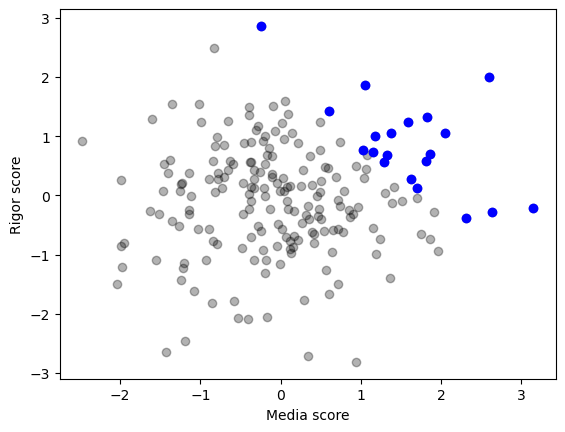

In [14]:
# Visualización
plt.plot(media_score, rigor_score, 'ok', alpha=0.3)
plt.plot(media_score[selected_works], rigor_score[selected_works], 'ob')
plt.xlabel("Media score")
plt.ylabel("Rigor score")

In [13]:
np.corrcoef(media_score, rigor_score)

array([[1.      , 0.082609],
       [0.082609, 1.      ]])

In [8]:
# Correlación
np.corrcoef(media_score[selected_works], rigor_score[selected_works])

array([[ 1.        , -0.62982255],
       [-0.62982255,  1.        ]])

Este mismo fenómeno de selección puede suceder en un modelo estadístico. Cuando pasa, puede distorcionar bastante nuestras inferencias.

## 2. Bias de colisión

Un DAG que modela la situación anterior es:

In [9]:
# Importar daft
import daft
# Importar causalgraphicalmodels
from causalgraphicalmodels import CausalGraphicalModel

In [10]:
# Función para dibujar modelos gráficos
def draw_dag(dag, coordinates):
    pgm = daft.PGM()
    for node in dag.dag.nodes:
        pgm.add_node(node, node, *coordinates[node])
    for edge in dag.dag.edges:
        pgm.add_edge(*edge)
    pgm.render()
    plt.gca().invert_yaxis()

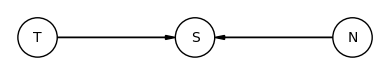

In [11]:
sci_dag = CausalGraphicalModel(
    nodes=["T", "S", "N"],
    edges=[("T", "S"), ("N", "S")]
)
coordinates = {"T": (0, 0), "S": (2, 0), "N": (4, 0)}

draw_dag(sci_dag, coordinates)

La confiabilidad $T$ y el interés público $N$ no están asociados, pero ambos influencian la selección $S$. Se llama **colisión** porque las flechas apuntan hacia $S$.

El concepto es: cuando se condiciona sobre el colisionador, se crea una asociación estadística (no necesariamente causal) entre las causas. Como vimos, una vez tenemos al top 10% de las propuestas, conocer su confiabilidad también nos da información de su interés público.

Esto significa que tenemos que prestar atención a los procesos que seleccionan explícita o implícitamente las muestras de nuestras observaciones, ya que pueden distorcionar las asociaciones entre las variables. También, este mismo fenómeno generará asociaciones falsas en un modelo estadístico, si incluimos al colisionador como predictor.

**¿La felicidad cambia con la edad?**

Consideremos ahora la pregunta de como envejecer influencia nuestra felicidad. Si tenemos una encuesta donde las personas declaran qué tan felices son, ¿Estará su edad asociada con la felicidad? Si sí, ¿es esta asociación causal?

Supongamos que la felicidad promedio es un rasgo de nacimiento, y no cambia con la edad. Sin embargo, la felicidad influencia los eventos de la vida misma. Por ejemplo, el matrimonio. La gente más feliz es más propensa a casarse. Otra variable que influencia el matrimonio es la edad. Mientras más años vives, más probable es que te cases. De modo que tenemos el siguiente modelo:

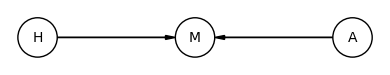

In [15]:
happiness_dag = CausalGraphicalModel(
    nodes=["H", "M", "A"],
    edges=[("H", "M"), ("A", "M")]
)
coordinates = {"H": (0, 0), "M": (2, 0), "A": (4, 0)}

draw_dag(happiness_dag, coordinates)

La felicidad $H$ y la edad $A$ causan el matrimonio $M$. Por tanto, el matrimonio es un colisionador. Incluso, si no hay una asociación entre felicidad y la edad, si condicionamos en el matrimonio (lo incluimos como predictor en la regresión), induciremos una asociación estadística entre la edad y la felicidad, distorsionando la interpretación de que la felicidad cambia con la edad, cuando en realidad es constante.

Veámoslo con una simulación, nuevamente. Las simulaciones son bastante útiles en este tipo de ejemplos, dado que son los únicos casos donde conocemos el modelo causal verdadero. Si un procedimiento no puede revelar la verdad en un ejemplo simulado, no le deberíamos confiar un caso real. La simulación consiste en lo siguiente:

1. Cada año, nacen 20 personas con valores de felicidad uniformemente distribuidos.
2. Cada año, cada persona envejece un año. La felicidad no cambia.
3. A los 18 años de edad, las personas se pueden casar. La probabilidad de casarse cada año son proporcionales a la felicidad del individuo.
4. Una vez casado, el individuo permanece casado.
5. Después de los 65 años, el individuo deja la muestra.

La simulación está en `helper.py`, en la función `sim_happiness`.

In [18]:
# Importar helper.sim_happiness
from helper import sim_happiness
# Importar arviz
import arviz as az

<frozen importlib._bootstrap>:241: RuntimeWarning: numpy.ndarray size changed, may indicate binary incompatibility. Expected 16 from C header, got 96 from PyObject


In [20]:
# Simular datos
happiness_data = sim_happiness(
    seed=1234
)
happiness_data.head()

,age,happiness,married
0,0.0,0.947368,False
1,0.0,2.000000,False
2,0.0,1.789474,False
3,0.0,1.578947,False
4,0.0,1.368421,False


In [24]:
happiness_data.shape

(1300, 3)

In [25]:
# Summary
happiness_data["married"] = happiness_data["married"].astype(int)
az.summary(happiness_data.to_dict(orient="list"), kind="stats", round_to=2)

,mean,sd,hdi_3%,hdi_97%
age,32.00,18.77,0.0,61.00
happiness,-0.00,1.21,-2.0,1.79
married,0.28,0.45,0.0,1.00


In [26]:
happiness_data.shape

(1300, 3)

Estos son los datos de 1300 personas de todas las edades entre 0 a 65 años. Las variables siguen el modelo descrito en el DAG de arriba.

Para visualizar los datos con estas tres variables haremos un gráfico un tanto ingenioso, con las variables de edad y felicidad en los ejes $x$ y $y$, respectivamente, y pintando los puntos de color cuando el individuo está casado:

In [27]:
happiness_data["married"] = happiness_data["married"].astype(bool)

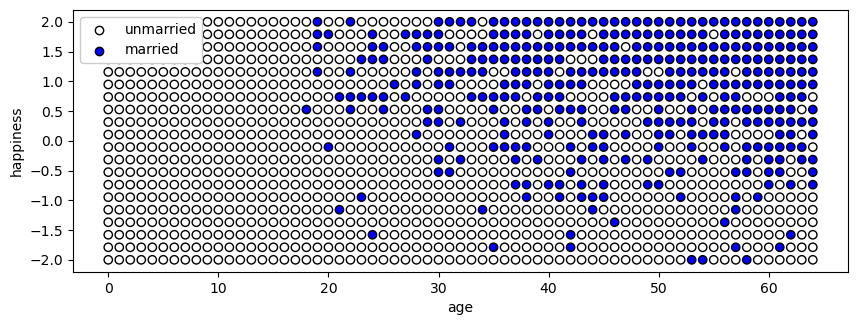

In [28]:
# Gráfica
fig, ax = plt.subplots(figsize=[10, 3.4])

colors = np.array(["w"] * happiness_data.shape[0])
colors[happiness_data["married"]] = "b"
ax.scatter(happiness_data["age"], happiness_data["happiness"], edgecolor="k", color=colors)

ax.scatter([], [], edgecolor="k", color="w", label="unmarried")
ax.scatter([], [], edgecolor="k", color="b", label="married")
ax.legend(loc="upper left", framealpha=1, frameon=True)

ax.set_xlabel("age")
ax.set_ylabel("happiness");

Supongamos que nos preguntamos si la edad se relaciona con la felicidad. No conocemos el modelo causal verdadero.

Consideramos una regresión lineal múltiple, para inferir la influencia de la edad en la felicidad, controlado para el estado marital:

$$
\mu_i = \alpha_{M[i]} + \beta_A A_i
$$

donde $M[i]$ es una variable índice que indica el estado marital de $i$.

Pensemos en la previa para $\beta_A$, no sin antes escalar la edad en el intervalo [0, 1]:

In [29]:
adult_happiness_data = happiness_data[happiness_data["age"] >= 18].copy()
adult_happiness_data["age_unit"] = (adult_happiness_data["age"] - 18) / (65 - 18)

Tenemos entonces que $A$ varía de 0 (18) a 1 (65). La escala de la felicidad va de -2 a +2, de forma que la relación más fuerte que podríamos encontrar sería $\frac{2 - (-2)}{1} = 4$.

Una previa que cubriría estos casos extremos sería:

$$
\beta_A \sim \text{Normal}(0, 2).
$$

Ahora, cada $\alpha$ es el valor de $\mu_i$ cuando $A_i=0$. En ese caso, debería $\alpha$ poder tomar todos los posibles valores de felicidad (de -2 a +2):

$$
\alpha_{M[i]} \sim \text{Normal}(0, 1).
$$

In [30]:
# Importar pymc
import pymc as pm

In [32]:
adult_happiness_data["married"] = adult_happiness_data["married"].astype(int)
# Modelo
with pm.Model() as happiness_model:
    sigma = pm.Exponential("sigma", 1)
    ba = pm.Normal("ba", 0, 2)
    a = pm.Normal("a", 0, 1, shape=2)
    mu = (
        a[adult_happiness_data["married"].values]
        + ba * adult_happiness_data["age_unit"].values
    )

    happiness = pm.Normal(
        "happiness",
        mu,
        sigma,
        observed=adult_happiness_data["happiness"].values
    )

    idata_happiness = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, ba, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


In [33]:
# Summary
az.summary(
    idata_happiness,
    kind="stats",
    hdi_prob=0.89
)

,mean,sd,hdi_5.5%,hdi_94.5%
ba,-0.719,0.120,-0.914,-0.532
a[0],-0.199,0.066,-0.303,-0.097
a[1],1.214,0.090,1.076,1.361
sigma,1.021,0.023,0.984,1.058


Observamos que el modelo nos muestra una gran seguridad de una asociación negativa entre la edad y la felicidad. Ahora, si descartamos el estado marital:

In [34]:
# Modelo
with pm.Model() as happiness_model_2:
    sigma = pm.Exponential("sigma", 1)
    ba = pm.Normal("ba", 0, 2)
    a = pm.Normal("a", 0, 1)
    mu = (
        a + ba * adult_happiness_data["age_unit"].values
    )

    happiness = pm.Normal(
        "happiness",
        mu,
        sigma,
        observed=adult_happiness_data["happiness"].values
    )

    idata_happiness_2 = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, ba, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


In [35]:
# Summary
az.summary(
    idata_happiness_2,
    kind="stats",
    hdi_prob=0.89
)

,mean,sd,hdi_5.5%,hdi_94.5%
ba,-0.006,0.138,-0.217,0.218
a,0.003,0.078,-0.124,0.125
sigma,1.216,0.029,1.169,1.263


Como contraste, vemos que en realidad no hay asociación entre edad y felicidad.

Esta patrón nos muestra exatamente lo que esperamos al condicionar (incluir como predictor) a un colisionador (estatus marital). Como vemos, al condicionar en un colisionador se induce una asociación falsa entre las dos causas.